### Import Data

In [1]:
#Import Libraries and functions
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
import random
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau

#Set seed for reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

#Path to dataset
data_dir = r'C:\Kuliah Tel U\KP\Data\Sunda'
image_paths = []
labels = []

#Image size and batch size
img_height, img_width = 100, 100
batch_size = 16


#Traverse through each class directory and add file paths and labels to the lists
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith(('png', 'jpg', 'jpeg')):
            image_paths.append(os.path.join(root, file))
            labels.append(root.split(os.path.sep)[-1])

#Create a DataFrame to hold the image paths and labels
image_df = pd.DataFrame({'image_path': image_paths, 'label': labels})


In [2]:
#Separate dataset into train (80%) and temp (20%)
train_df, temp_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

#Split temp_df into validation (10%) and test (10%)
val_df, test_df = train_test_split(temp_df, test_size=0.5, shuffle=True, random_state=42)

#Check the sizes of each set
print(f"Training set: {len(train_df)}")
print(f"Validation set: {len(val_df)}")
print(f"Test set: {len(test_df)}")


Training set: 1728
Validation set: 216
Test set: 216


In [3]:
#Function to load images and preprocess the data
def load_images_from_df(df, img_height, img_width):
    images = []
    labels = []
    
    for _, row in df.iterrows():
        img = Image.open(row['image_path']).convert('L')  #Convert to grayscale
        img = np.array(img.resize((img_height, img_width))) / 255.0 #Normalize  
        img = (img > 0.5).astype(np.float32) #Tresholding
        images.append(img)
        labels.append(row['label'])
    
    return np.array(images), np.array(labels)


In [4]:
label_encoder = LabelEncoder()

#Load images with preprocessing
train_images, train_labels = load_images_from_df(train_df, 100, 100)
val_images, val_labels = load_images_from_df(val_df, 100, 100)
test_images, test_labels = load_images_from_df(test_df, 100, 100)

#Add channel dimension for grayscale (since you're using CNN)
train_images = np.expand_dims(train_images, axis=-1)
val_images = np.expand_dims(val_images, axis=-1)
test_images = np.expand_dims(test_images, axis=-1)

#Convert labels to categorical
train_labels_categorical = to_categorical(label_encoder.fit_transform(train_labels))
val_labels_categorical = to_categorical(label_encoder.transform(val_labels))
test_labels_categorical = to_categorical(label_encoder.transform(test_labels))

In [5]:
#Check the shapes to confirm data loading
print(f"Train images shape: {train_images.shape}")
print(f"Train labels shape: {train_labels_categorical.shape}")
print(f"Validation images shape: {val_images.shape}")
print(f"Validation labels shape: {val_labels_categorical.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Test labels shape: {test_labels_categorical.shape}")

Train images shape: (1728, 100, 100, 1)
Train labels shape: (1728, 108)
Validation images shape: (216, 100, 100, 1)
Validation labels shape: (216, 108)
Test images shape: (216, 100, 100, 1)
Test labels shape: (216, 108)


### First Model

A simple CNN sequential model with 4 Convolutional Blocks, with each block having its own number of neurons, a flattening layer to flattens the 2D output of the final convolutional layer into a 1D vector to prepare it for fully connected layers (Dense layers).There are 2 fully connected layers, the first one has 512 neurons, and the second one has 256 neurons, each of the layers starting from the input to the dense layers use relu as an activation function. The final Dense layer (output) has 108 neurons with a softmax activation function. The model is compiled using the 'adam' optimizer for efficient gradient descent, and the loss function is categorical_crossentropy. The accuracy metric is used to monitor performance during training. The training is conducted over 100 epochs with a batch size of 16.

In [6]:
input_shape = (100, 100, 1)
num_classes = 108

model1 = Sequential()

#First Convolutional Block
model1.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.25))

#Second Convolutional Block
model1.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.25))

#Third Convolutional Block
model1.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.25))

#Fourth Convolutional Block
model1.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.25))

#Flatten the output of the last convolutional layer
model1.add(Flatten())

#Fully Connected Block
model1.add(Dense(512, activation='relu'))
model1.add(BatchNormalization())
model1.add(Dropout(0.5))

model1.add(Dense(256, activation='relu'))
model1.add(Dropout(0.5))

#Output Layer (108 classes)
model1.add(Dense(num_classes, activation='softmax'))


model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 64)      640       
                                                                 
 batch_normalization (BatchN  (None, 100, 100, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 50, 50, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 batch_normalization_1 (Batc  (None, 50, 50, 128)      5

### Training The Model

In [7]:
history1 = model1.fit(
    train_images, train_labels_categorical,
    validation_data=(val_images, val_labels_categorical),
    epochs=100,
    batch_size=batch_size,
    verbose=1
)

Epoch 1/100
108/108 [==============================] - 14s 42ms/step - loss: 5.0827 - accuracy: 0.0417 - val_loss: 17.1778 - val_accuracy: 0.0093
Epoch 2/100
108/108 [==============================] - 4s 37ms/step - loss: 4.0705 - accuracy: 0.1036 - val_loss: 14.0010 - val_accuracy: 0.0093
Epoch 3/100
108/108 [==============================] - 4s 37ms/step - loss: 3.4346 - accuracy: 0.1649 - val_loss: 10.1487 - val_accuracy: 0.0046
Epoch 4/100
108/108 [==============================] - 4s 37ms/step - loss: 2.9123 - accuracy: 0.2506 - val_loss: 9.0807 - val_accuracy: 0.0000e+00
Epoch 5/100
108/108 [==============================] - 4s 38ms/step - loss: 2.5267 - accuracy: 0.3050 - val_loss: 6.9627 - val_accuracy: 0.0463
Epoch 6/100
108/108 [==============================] - 4s 37ms/step - loss: 2.2666 - accuracy: 0.3605 - val_loss: 3.1925 - val_accuracy: 0.2361
Epoch 7/100
108/108 [==============================] - 4s 37ms/step - loss: 2.0304 - accuracy: 0.4028 - val_loss: 2.0337 - val_a

In [8]:
#Evaluate the model on the test set
test_loss, test_accuracy = model1.evaluate(test_images, test_labels_categorical, verbose=1)
print(f'Test Accuracy: {test_accuracy:.4f}')

7/7 [==============================] - 1s 100ms/step - loss: 0.6101 - accuracy: 0.8657
Test Accuracy: 0.8657


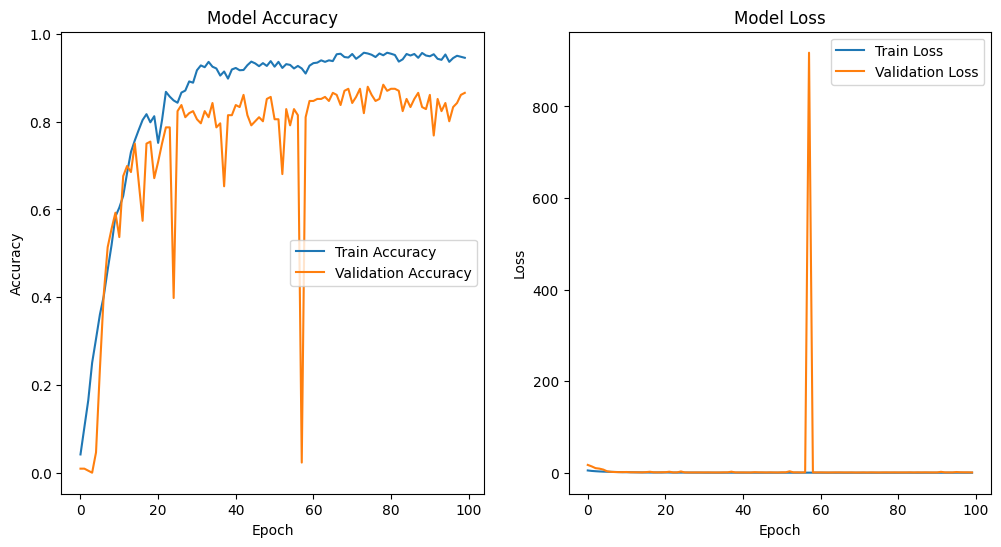

In [9]:
#Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

#Model accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'], label='Train Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

#Model loss plot
plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


While the first CNN Model shows that the trainning accuracy(94,56%), validation accuracy(86,57%), and testing accuracy(86,57%) are good, we cannot ignore the erratic behavior of the validation accuracy and validation loss in the training history, which shows that there may still be overfitting in the model.

### Model Improvement Attempt 1

The first improvements attempt made were increased dropout rate for the Convolutional Blocks (from 0.25 to 0.3) and Fully Connected Layers (from 0.5 to 0.6), lower learning rate (from the default of Adam Optimizer 0.001 to 0.0001). Additionally, the batch size was increased from 16 to 32 during model training.  

In [10]:
input_shape = (100, 100, 1)
num_classes = 108

model2 = Sequential()

#First Convolutional Block
model2.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.3))  #Increased dropout to 0.3 for all the convolutional blocks

#Second Convolutional Block
model2.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.3))  

#Third Convolutional Block
model2.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.3))  

#Fourth Convolutional Block
model2.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.3))  

#Flatten the output of the last convolutional layer
model2.add(Flatten())

#Fully Connected Block
model2.add(Dense(512, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.6))  #Increased dropout to 0.6 for Fully Connected Blocks

model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.6)) 

#Output Layer
model2.add(Dense(num_classes, activation='softmax'))

model2.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy']) #Decrease learning rate for adam optimizer from 0.001 to 0.0001
model2.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 100, 100, 64)      640       
                                                                 
 batch_normalization_5 (Batc  (None, 100, 100, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 50, 50, 64)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 50, 50, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 batch_normalization_6 (Batc  (None, 50, 50, 128)     

In [11]:
#Train the model
history2 = model2.fit(
    train_images, train_labels_categorical,
    validation_data=(val_images, val_labels_categorical), 
    epochs=100,  
    batch_size=32, #Increase in batch size
    verbose=1
)

Epoch 1/100
54/54 [==============================] - 7s 74ms/step - loss: 6.8182 - accuracy: 0.0156 - val_loss: 4.9178 - val_accuracy: 0.0046
Epoch 2/100
54/54 [==============================] - 4s 69ms/step - loss: 6.0977 - accuracy: 0.0203 - val_loss: 5.3868 - val_accuracy: 0.0046
Epoch 3/100
54/54 [==============================] - 4s 67ms/step - loss: 5.7450 - accuracy: 0.0220 - val_loss: 6.2694 - val_accuracy: 0.0046
Epoch 4/100
54/54 [==============================] - 4s 67ms/step - loss: 5.4506 - accuracy: 0.0382 - val_loss: 7.1009 - val_accuracy: 0.0093
Epoch 5/100
54/54 [==============================] - 4s 68ms/step - loss: 5.2344 - accuracy: 0.0399 - val_loss: 7.6296 - val_accuracy: 0.0139
Epoch 6/100
54/54 [==============================] - 4s 68ms/step - loss: 5.0195 - accuracy: 0.0561 - val_loss: 8.1904 - val_accuracy: 0.0093
Epoch 7/100
54/54 [==============================] - 4s 67ms/step - loss: 4.8953 - accuracy: 0.0596 - val_loss: 8.6841 - val_accuracy: 0.0093
Epoch 

In [12]:
#Evaluate the model on the test set
test_loss, test_accuracy = model2.evaluate(test_images, test_labels_categorical, verbose=1)
print(f'Test Accuracy: {test_accuracy:.4f}')

7/7 [==============================] - 0s 15ms/step - loss: 1.2308 - accuracy: 0.6111
Test Accuracy: 0.6111


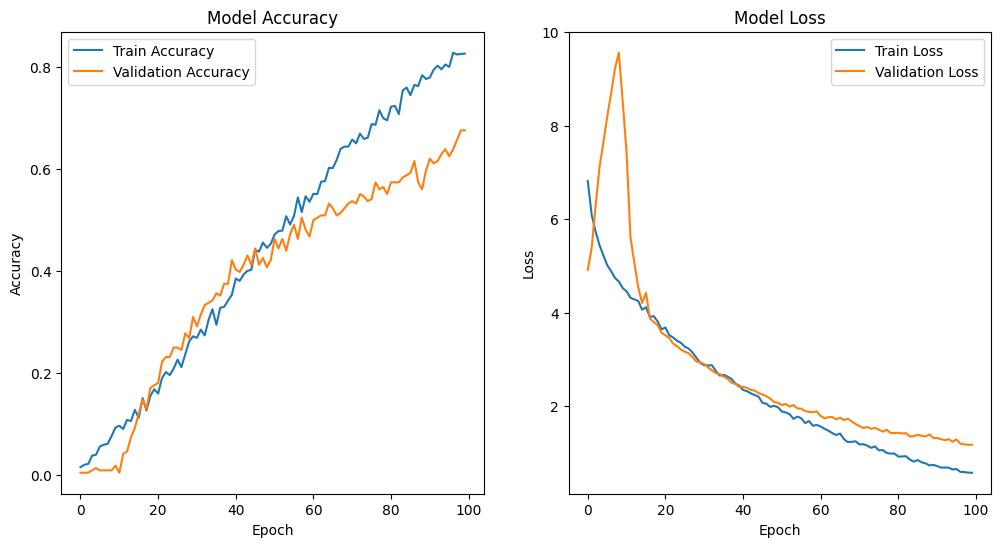

In [13]:
#Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

#Model accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

#Model loss plot
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


The first attempt of improving the model didn't go well. The model only achieved a training accuracy of 82,64%, validation accuracy of 67,59%, and a test accuracy of 61,11%. But the model shows a much better generalization because the model loss and model accuracy was not as erratic as the one from the first model.

### Model Improvement Attempt 2

The second improvements attempt made were the decrease in amount of neurons in all of the blocks, increase in dropout rate in the dense layer, and increase in learning rate to furthermore combat overfitting.

In [14]:
input_shape = (100, 100, 1)
num_classes = 108

model3 = Sequential()

#First Convolutional Block
model3.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape)) #Decrease the number of neurons in all of the blocks
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.3))

#Second Convolutional Block
model3.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.3))

#Third Convolutional Block
model3.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.3))

#Fourth Convolutional Block
model3.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.3))

#Flatten the output of the last convolutional layer
model3.add(Flatten())

#Fully Connected Block
model3.add(Dense(256, activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.7)) #Increased dropout rate at the dense layer

model3.add(Dense(128, activation='relu'))
model3.add(Dropout(0.7)) 

#Output Layer
model3.add(Dense(num_classes, activation='softmax'))

#Compile the model
model3.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy']) #Increased learning rate

model3.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 100, 100, 32)      320       
                                                                 
 batch_normalization_10 (Bat  (None, 100, 100, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 50, 50, 32)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 batch_normalization_11 (Bat  (None, 50, 50, 64)      

In [15]:
history3 = model3.fit(
    train_images, train_labels_categorical, 
    validation_data=(val_images, val_labels_categorical),  
    epochs=100,
    batch_size=32, 
    verbose=1
)

Epoch 1/100
54/54 [==============================] - 4s 41ms/step - loss: 7.0541 - accuracy: 0.0122 - val_loss: 5.1593 - val_accuracy: 0.0093
Epoch 2/100
54/54 [==============================] - 2s 33ms/step - loss: 6.2283 - accuracy: 0.0145 - val_loss: 5.8954 - val_accuracy: 0.0046
Epoch 3/100
54/54 [==============================] - 2s 33ms/step - loss: 5.8488 - accuracy: 0.0127 - val_loss: 6.0087 - val_accuracy: 0.0139
Epoch 4/100
54/54 [==============================] - 2s 33ms/step - loss: 5.5704 - accuracy: 0.0197 - val_loss: 5.5197 - val_accuracy: 0.0139
Epoch 5/100
54/54 [==============================] - 2s 33ms/step - loss: 5.3747 - accuracy: 0.0220 - val_loss: 5.7455 - val_accuracy: 0.0046
Epoch 6/100
54/54 [==============================] - 2s 32ms/step - loss: 5.1126 - accuracy: 0.0284 - val_loss: 5.7924 - val_accuracy: 0.0000e+00
Epoch 7/100
54/54 [==============================] - 2s 32ms/step - loss: 5.0199 - accuracy: 0.0307 - val_loss: 6.0826 - val_accuracy: 0.0093
Ep

In [16]:
#Evaluate the model on the test set
test_loss, test_accuracy = model3.evaluate(test_images, test_labels_categorical, verbose=1)
print(f'Test Accuracy: {test_accuracy:.4f}')

7/7 [==============================] - 0s 10ms/step - loss: 1.1690 - accuracy: 0.6898
Test Accuracy: 0.6898


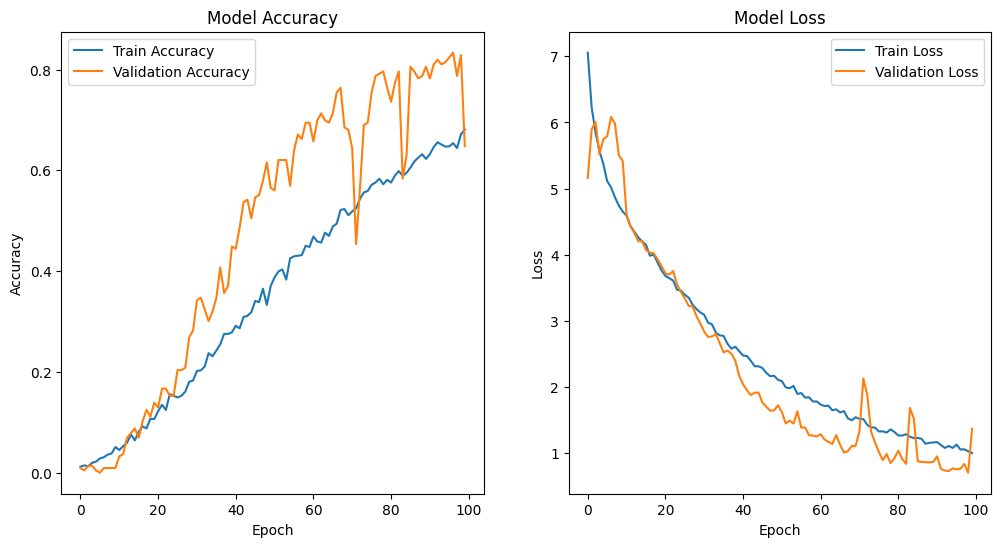

In [17]:
#Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

#Model accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history3.history['accuracy'], label='Train Accuracy')
plt.plot(history3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

#Model loss plot
plt.subplot(1, 2, 2)
plt.plot(history3.history['loss'], label='Train Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

The second attempt of improving the model showed better results. The model achieved a training accuracy of 68.11%, validation accuracy of 64.81%, and a test accuracy of 68.98%. The model demonstrated much better generalization, as both the model loss and accuracy showed smoother and more consistent improvements compared to previous models. Although there were still slight fluctuations in the validation loss, the overall performance significantly improved, indicating the adjustments made a positive impact.

### Model Improvement Attempt 3

Because the model is underfitting, the third improvement attempt involved increasing the number of neurons in both the convolutional blocks and fully connected layers to enhance the model's capacity to learn complex patterns. The dropout rate and learning rate remained the same to maintain regularization and avoid overfitting despite the increased complexity. And in this improvement, we compare the effect of Adam Optimizer's learning rate on the model (between 0.0005, 0.0003, and 0.0007). Additionally, the batch size was decreased (32 to 16) to improve generalization.

In [24]:
input_shape = (100, 100, 1)
num_classes = 108

model4 = Sequential()

#First Convolutional Block
model4.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))  #Increased all neurons
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.3))

#Second Convolutional Block
model4.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.3))

#Third Convolutional Block
model4.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.3))

#Fourth Convolutional Block
model4.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.3))

#Flatten the output of the last convolutional layer
model4.add(Flatten())

#Fully Connected Block
model4.add(Dense(512, activation='relu'))
model4.add(BatchNormalization())
model4.add(Dropout(0.7))

model4.add(Dense(256, activation='relu')) 
model4.add(Dropout(0.7))  

#Output Layer
model4.add(Dense(num_classes, activation='softmax'))
model4.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy']) #0.0005 Learning Rate
model4.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 100, 100, 64)      640       
                                                                 
 batch_normalization_25 (Bat  (None, 100, 100, 64)     256       
 chNormalization)                                                
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 50, 50, 64)       0         
 g2D)                                                            
                                                                 
 dropout_30 (Dropout)        (None, 50, 50, 64)        0         
                                                                 
 conv2d_21 (Conv2D)          (None, 50, 50, 128)       73856     
                                                                 
 batch_normalization_26 (Bat  (None, 50, 50, 128)     

In [25]:
history4 = model4.fit(
    train_images, train_labels_categorical, 
    validation_data=(val_images, val_labels_categorical),  
    epochs=100,
    batch_size=16, #Decrease in batch size
    verbose=1
)

Epoch 1/100
108/108 [==============================] - 6s 42ms/step - loss: 7.1193 - accuracy: 0.0116 - val_loss: 7.1010 - val_accuracy: 0.0139
Epoch 2/100
108/108 [==============================] - 4s 40ms/step - loss: 6.2325 - accuracy: 0.0220 - val_loss: 9.0015 - val_accuracy: 0.0093
Epoch 3/100
108/108 [==============================] - 4s 40ms/step - loss: 5.6313 - accuracy: 0.0260 - val_loss: 11.6904 - val_accuracy: 0.0093
Epoch 4/100
108/108 [==============================] - 4s 40ms/step - loss: 5.0858 - accuracy: 0.0469 - val_loss: 7.2891 - val_accuracy: 0.0139
Epoch 5/100
108/108 [==============================] - 4s 40ms/step - loss: 4.8357 - accuracy: 0.0434 - val_loss: 5.3551 - val_accuracy: 0.0093
Epoch 6/100
108/108 [==============================] - 4s 40ms/step - loss: 4.4727 - accuracy: 0.0625 - val_loss: 4.3033 - val_accuracy: 0.0833
Epoch 7/100
108/108 [==============================] - 4s 39ms/step - loss: 4.3367 - accuracy: 0.0648 - val_loss: 4.1490 - val_accuracy

In [26]:
#Evaluate the model on the test set
test_loss, test_accuracy = model4.evaluate(test_images, test_labels_categorical, verbose=1)
print(f'Test Accuracy: {test_accuracy:.4f}')

7/7 [==============================] - 0s 15ms/step - loss: 0.6218 - accuracy: 0.8426
Test Accuracy: 0.8426


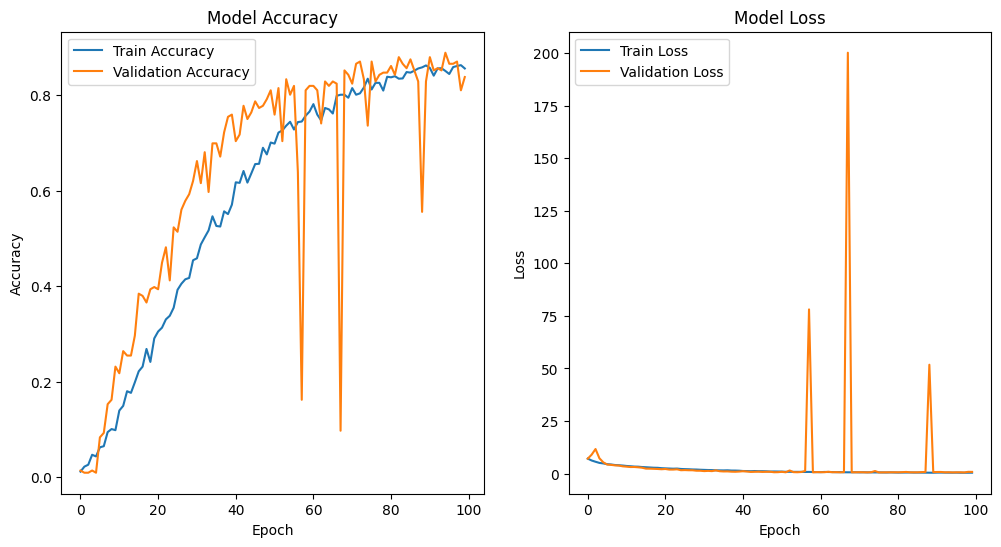

In [27]:
#Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

#Model accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history4.history['accuracy'], label='Train Accuracy')
plt.plot(history4.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

#Model loss plot
plt.subplot(1, 2, 2)
plt.plot(history4.history['loss'], label='Train Loss')
plt.plot(history4.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

The first model used a learning rate of 0.0005, where it shows less underfitting but still has a lot of erratic spikes for the validation accuracy and loss. This model has a better training accuracy (84,26%) than the model before.

In [28]:
input_shape = (100, 100, 1)
num_classes = 108

model4 = Sequential()

#First Convolutional Block
model4.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))  #Increased all neurons
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.3))

#Second Convolutional Block
model4.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.3))

#Third Convolutional Block
model4.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.3))

#Fourth Convolutional Block
model4.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.3))

#Flatten the output of the last convolutional layer
model4.add(Flatten())

#Fully Connected Block
model4.add(Dense(512, activation='relu'))
model4.add(BatchNormalization())
model4.add(Dropout(0.7))

model4.add(Dense(256, activation='relu')) 
model4.add(Dropout(0.7))  

#Output Layer
model4.add(Dense(num_classes, activation='softmax'))
model4.compile(optimizer=Adam(learning_rate=0.0003), loss='categorical_crossentropy', metrics=['accuracy']) #0.0003 Learning Rate
model4.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 100, 100, 64)      640       
                                                                 
 batch_normalization_30 (Bat  (None, 100, 100, 64)     256       
 chNormalization)                                                
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 50, 50, 64)       0         
 g2D)                                                            
                                                                 
 dropout_36 (Dropout)        (None, 50, 50, 64)        0         
                                                                 
 conv2d_25 (Conv2D)          (None, 50, 50, 128)       73856     
                                                                 
 batch_normalization_31 (Bat  (None, 50, 50, 128)     

In [29]:
history4 = model4.fit(
    train_images, train_labels_categorical, 
    validation_data=(val_images, val_labels_categorical),  
    epochs=100,
    batch_size=16, 
    verbose=1
)

Epoch 1/100
108/108 [==============================] - 6s 43ms/step - loss: 7.1296 - accuracy: 0.0179 - val_loss: 6.9221 - val_accuracy: 0.0000e+00
Epoch 2/100
108/108 [==============================] - 5s 42ms/step - loss: 6.3121 - accuracy: 0.0214 - val_loss: 10.0814 - val_accuracy: 0.0000e+00
Epoch 3/100
108/108 [==============================] - 4s 41ms/step - loss: 5.8546 - accuracy: 0.0255 - val_loss: 15.4844 - val_accuracy: 0.0000e+00
Epoch 4/100
108/108 [==============================] - 4s 40ms/step - loss: 5.5731 - accuracy: 0.0266 - val_loss: 6.3399 - val_accuracy: 0.0000e+00
Epoch 5/100
108/108 [==============================] - 4s 40ms/step - loss: 5.2833 - accuracy: 0.0330 - val_loss: 4.8245 - val_accuracy: 0.0093
Epoch 6/100
108/108 [==============================] - 4s 40ms/step - loss: 5.0282 - accuracy: 0.0475 - val_loss: 4.6004 - val_accuracy: 0.0185
Epoch 7/100
108/108 [==============================] - 4s 40ms/step - loss: 4.9036 - accuracy: 0.0463 - val_loss: 4.14

In [30]:
#Evaluate the model on the test set
test_loss, test_accuracy = model4.evaluate(test_images, test_labels_categorical, verbose=1)
print(f'Test Accuracy: {test_accuracy:.4f}')

7/7 [==============================] - 0s 15ms/step - loss: 0.5056 - accuracy: 0.8519
Test Accuracy: 0.8519


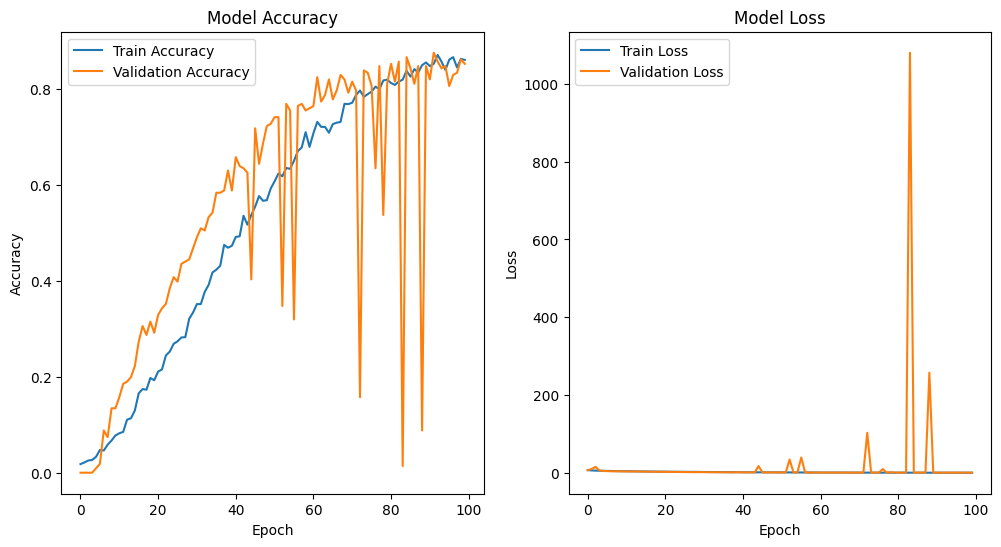

In [31]:
#Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

#Model accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history4.history['accuracy'], label='Train Accuracy')
plt.plot(history4.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

#Model loss plot
plt.subplot(1, 2, 2)
plt.plot(history4.history['loss'], label='Train Loss')
plt.plot(history4.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

The second model used a learning rate of 0.0003, where it shows less underfitting and yet again still has a lot of erratic spikes for the validation accuracy and loss. But this model has the best testing accuracy so far at 85,19%.

In [38]:
input_shape = (100, 100, 1)
num_classes = 108

model4 = Sequential()

#First Convolutional Block
model4.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))  #Increased all neurons
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.3))

#Second Convolutional Block
model4.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.3))

#Third Convolutional Block
model4.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.3))

#Fourth Convolutional Block
model4.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.3))

#Flatten the output of the last convolutional layer
model4.add(Flatten())

#Fully Connected Block
model4.add(Dense(512, activation='relu'))
model4.add(BatchNormalization())
model4.add(Dropout(0.7))

model4.add(Dense(256, activation='relu')) 
model4.add(Dropout(0.7))  

#Output Layer
model4.add(Dense(num_classes, activation='softmax'))
model4.compile(optimizer=Adam(learning_rate=0.0007), loss='categorical_crossentropy', metrics=['accuracy']) #0.0007 Learning Rate
model4.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 100, 100, 64)      640       
                                                                 
 batch_normalization_45 (Bat  (None, 100, 100, 64)     256       
 chNormalization)                                                
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 50, 50, 64)       0         
 g2D)                                                            
                                                                 
 dropout_54 (Dropout)        (None, 50, 50, 64)        0         
                                                                 
 conv2d_37 (Conv2D)          (None, 50, 50, 128)       73856     
                                                                 
 batch_normalization_46 (Bat  (None, 50, 50, 128)     

In [39]:
history4 = model4.fit(
    train_images, train_labels_categorical, 
    validation_data=(val_images, val_labels_categorical),  
    epochs=100,
    batch_size=16, 
    verbose=1
)

Epoch 1/100
108/108 [==============================] - 6s 41ms/step - loss: 6.9327 - accuracy: 0.0081 - val_loss: 6.7631 - val_accuracy: 0.0046
Epoch 2/100
108/108 [==============================] - 4s 39ms/step - loss: 5.8183 - accuracy: 0.0284 - val_loss: 7.7122 - val_accuracy: 0.0139
Epoch 3/100
108/108 [==============================] - 4s 39ms/step - loss: 5.3085 - accuracy: 0.0289 - val_loss: 11.1378 - val_accuracy: 0.0185
Epoch 4/100
108/108 [==============================] - 4s 39ms/step - loss: 4.8216 - accuracy: 0.0394 - val_loss: 8.5018 - val_accuracy: 0.0185
Epoch 5/100
108/108 [==============================] - 4s 38ms/step - loss: 4.4841 - accuracy: 0.0689 - val_loss: 4.9900 - val_accuracy: 0.0093
Epoch 6/100
108/108 [==============================] - 4s 38ms/step - loss: 4.3079 - accuracy: 0.0712 - val_loss: 4.6009 - val_accuracy: 0.0417
Epoch 7/100
108/108 [==============================] - 4s 38ms/step - loss: 4.0650 - accuracy: 0.1042 - val_loss: 4.2750 - val_accuracy

In [40]:
#Evaluate the model on the test set
test_loss, test_accuracy = model4.evaluate(test_images, test_labels_categorical, verbose=1)
print(f'Test Accuracy: {test_accuracy:.4f}')

7/7 [==============================] - 0s 15ms/step - loss: 0.4277 - accuracy: 0.8796
Test Accuracy: 0.8796


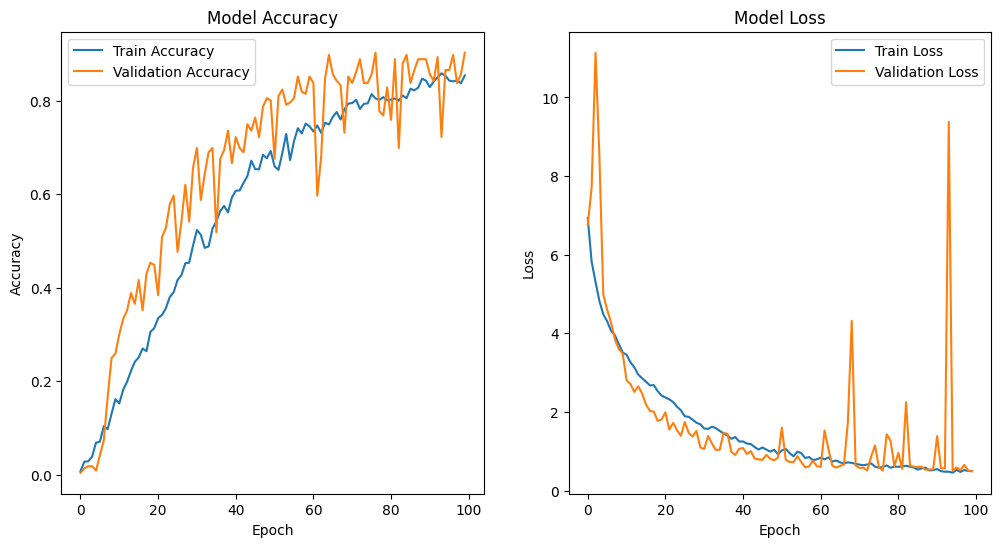

In [41]:
#Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

#Model accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history4.history['accuracy'], label='Train Accuracy')
plt.plot(history4.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

#Model loss plot
plt.subplot(1, 2, 2)
plt.plot(history4.history['loss'], label='Train Loss')
plt.plot(history4.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

The third model used a learning rate of 0.0007, where it shows less underfitting and an even better testing accuracy out of the three learning rates at 87,96%, and now it has less erratic spikes than the rest.

The third attempt at improving the model showed better results. Increasing the number of neurons and experimenting with different learning rates helped reduce underfitting overall. Among the three models tested in this attempt, the model with the lowest learning rate (0.0007) achieved the best performance, with a training accuracy of 87.96%, validation accuracy of 90.28%, and testing accuracy of 85.42%. These results suggest that the model exhibits little to no overfitting or underfitting.

### Model Improvemetn Attempt 4

The fourth improvement attempt involved adding image augmentation techniques to the training process, maintaining the same number of neurons in all blocks, and increasing the learning rate to 0.0007 to further combat overfitting.

In [44]:
#Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

#Fit the data generator
datagen.fit(train_images)

input_shape = (100, 100, 1)
num_classes = 108

model5 = Sequential()

#First Convolutional Block
model5.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
model5.add(BatchNormalization())
model5.add(MaxPooling2D(pool_size=(2, 2)))
model5.add(Dropout(0.3))

#Second Convolutional Block
model5.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model5.add(BatchNormalization())
model5.add(MaxPooling2D(pool_size=(2, 2)))
model5.add(Dropout(0.3))

#Third Convolutional Block
model5.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model5.add(BatchNormalization())
model5.add(MaxPooling2D(pool_size=(2, 2)))
model5.add(Dropout(0.3))

#Fourth Convolutional Block
model5.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model5.add(BatchNormalization())
model5.add(MaxPooling2D(pool_size=(2, 2)))
model5.add(Dropout(0.3))

#Flatten the output of the last convolutional layer
model5.add(Flatten())

#Fully Connected Block
model5.add(Dense(512, activation='relu'))
model5.add(BatchNormalization())
model5.add(Dropout(0.7))

model5.add(Dense(256, activation='relu')) 
model5.add(Dropout(0.7))  

#Output Layer
model5.add(Dense(num_classes, activation='softmax'))
model5.compile(optimizer=Adam(learning_rate=0.0007), loss='categorical_crossentropy', metrics=['accuracy'])
model5.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 100, 100, 64)      640       
                                                                 
 batch_normalization_55 (Bat  (None, 100, 100, 64)     256       
 chNormalization)                                                
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 50, 50, 64)       0         
 g2D)                                                            
                                                                 
 dropout_66 (Dropout)        (None, 50, 50, 64)        0         
                                                                 
 conv2d_45 (Conv2D)          (None, 50, 50, 128)       73856     
                                                                 
 batch_normalization_56 (Bat  (None, 50, 50, 128)    

In [45]:
history5 = model5.fit(
    datagen.flow(train_images, train_labels_categorical, batch_size=16),
    validation_data=(val_images, val_labels_categorical),  
    epochs=100, 
    verbose=1
)

Epoch 1/100
108/108 [==============================] - 6s 42ms/step - loss: 7.3216 - accuracy: 0.0058 - val_loss: 5.6792 - val_accuracy: 0.0139
Epoch 2/100
108/108 [==============================] - 4s 39ms/step - loss: 6.2356 - accuracy: 0.0145 - val_loss: 5.2516 - val_accuracy: 0.0139
Epoch 3/100
108/108 [==============================] - 4s 38ms/step - loss: 5.5659 - accuracy: 0.0191 - val_loss: 5.0788 - val_accuracy: 0.0046
Epoch 4/100
108/108 [==============================] - 4s 39ms/step - loss: 5.1780 - accuracy: 0.0139 - val_loss: 4.9851 - val_accuracy: 0.0093
Epoch 5/100
108/108 [==============================] - 4s 40ms/step - loss: 4.9246 - accuracy: 0.0243 - val_loss: 4.6328 - val_accuracy: 0.0231
Epoch 6/100
108/108 [==============================] - 4s 40ms/step - loss: 4.7459 - accuracy: 0.0284 - val_loss: 4.5459 - val_accuracy: 0.0093
Epoch 7/100
108/108 [==============================] - 4s 40ms/step - loss: 4.6603 - accuracy: 0.0243 - val_loss: 4.4152 - val_accuracy:

In [46]:
#Evaluate the model on the test set
test_loss, test_accuracy = model5.evaluate(test_images, test_labels_categorical, verbose=1)
print(f'Test Accuracy: {test_accuracy:.4f}')


7/7 [==============================] - 0s 16ms/step - loss: 1.0797 - accuracy: 0.6528
Test Accuracy: 0.6528


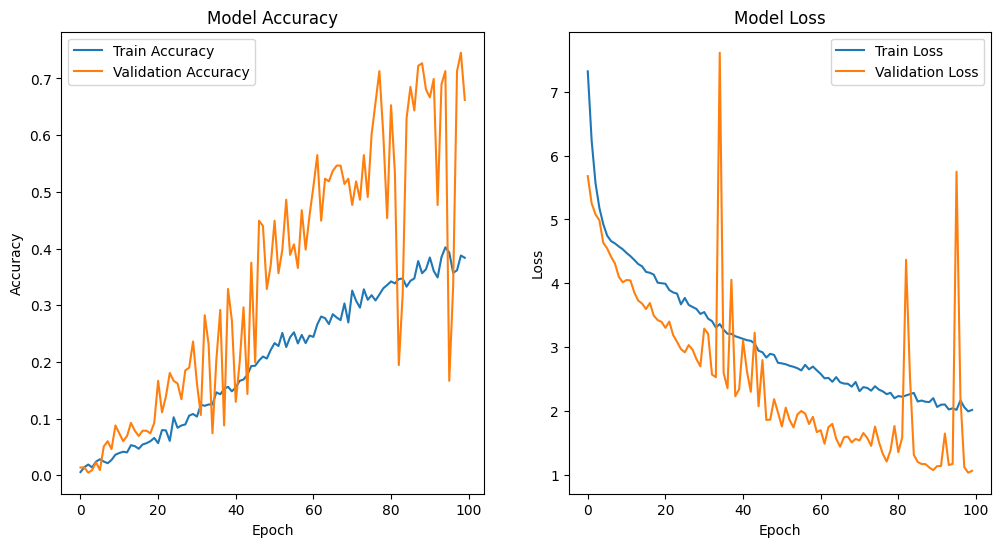

In [47]:
#Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

#Model accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history5.history['accuracy'], label='Train Accuracy')
plt.plot(history5.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

#Model loss plot
plt.subplot(1, 2, 2)
plt.plot(history5.history['loss'], label='Train Loss')
plt.plot(history5.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

The fourth improvement introduced data augmentation and a higher learning rate, which helped reduce overfitting but also caused instability in validation performance. The test accuracy was 65.28%, showing moderate generalization, but the model needs further tuning to improve both training and validation consistency.

### Model Improvement Attempt 5

The fifth improvement attempt involved reducing the dropout rate in the fully connected layers from 0.7 to 0.5, while maintaining the same number of neurons in all of the blocks and keeping the learning rate at 0.0007 to further improve generalization.

In [6]:
#Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

#Fit the data generator
datagen.fit(train_images)

input_shape = (100, 100, 1)
num_classes = 108

model6 = Sequential()

#First Convolutional Block
model6.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
model6.add(BatchNormalization())
model6.add(MaxPooling2D(pool_size=(2, 2)))
model6.add(Dropout(0.3))

#Second Convolutional Block
model6.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model6.add(BatchNormalization())
model6.add(MaxPooling2D(pool_size=(2, 2)))
model6.add(Dropout(0.3))

#Third Convolutional Block
model6.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model6.add(BatchNormalization())
model6.add(MaxPooling2D(pool_size=(2, 2)))
model6.add(Dropout(0.3))

#Fourth Convolutional Block
model6.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model6.add(BatchNormalization())
model6.add(MaxPooling2D(pool_size=(2, 2)))
model6.add(Dropout(0.3))

#Flatten the output of the last convolutional layer
model6.add(Flatten())

#Fully Connected Block
model6.add(Dense(512, activation='relu'))
model6.add(BatchNormalization())
model6.add(Dropout(0.5)) #Reduce Dropout rate to 0,5

model6.add(Dense(256, activation='relu')) 
model6.add(Dropout(0.5))  

#Output Layer
model6.add(Dense(num_classes, activation='softmax'))
model6.compile(optimizer=Adam(learning_rate=0.0007), loss='categorical_crossentropy', metrics=['accuracy'])
model6.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 64)      640       
                                                                 
 batch_normalization (BatchN  (None, 100, 100, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 50, 50, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 batch_normalization_1 (Batc  (None, 50, 50, 128)      5

In [7]:
history6 = model6.fit(
    datagen.flow(train_images, train_labels_categorical, batch_size=16),
    validation_data=(val_images, val_labels_categorical),  
    epochs=100, 
    verbose=1
)

Epoch 1/100
108/108 [==============================] - 11s 51ms/step - loss: 5.4286 - accuracy: 0.0243 - val_loss: 8.1461 - val_accuracy: 0.0139
Epoch 2/100
108/108 [==============================] - 4s 39ms/step - loss: 4.9485 - accuracy: 0.0347 - val_loss: 13.1581 - val_accuracy: 0.0139
Epoch 3/100
108/108 [==============================] - 4s 39ms/step - loss: 4.6406 - accuracy: 0.0463 - val_loss: 12.8969 - val_accuracy: 0.0046
Epoch 4/100
108/108 [==============================] - 4s 39ms/step - loss: 4.4102 - accuracy: 0.0532 - val_loss: 14.1306 - val_accuracy: 0.0093
Epoch 5/100
108/108 [==============================] - 4s 39ms/step - loss: 4.1741 - accuracy: 0.0758 - val_loss: 5.5967 - val_accuracy: 0.0046
Epoch 6/100
108/108 [==============================] - 4s 38ms/step - loss: 4.0029 - accuracy: 0.0775 - val_loss: 4.0860 - val_accuracy: 0.0556
Epoch 7/100
108/108 [==============================] - 4s 38ms/step - loss: 3.8769 - accuracy: 0.0885 - val_loss: 3.3466 - val_accur

In [8]:
#Evaluate the model on the test set
test_loss, test_accuracy = model6.evaluate(test_images, test_labels_categorical, verbose=1)
print(f'Test Accuracy: {test_accuracy:.4f}')

7/7 [==============================] - 0s 15ms/step - loss: 0.2228 - accuracy: 0.9213
Test Accuracy: 0.9213


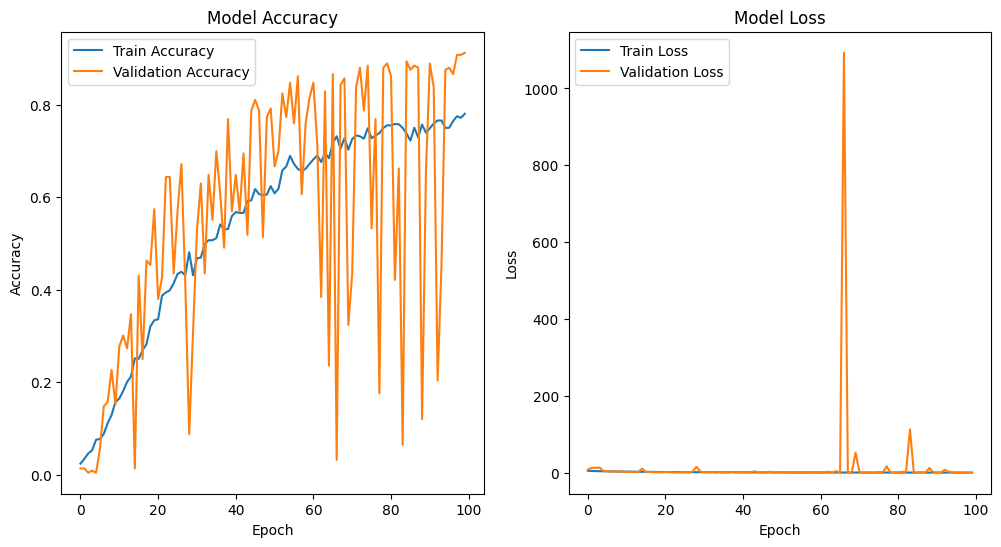

In [9]:
#Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

#Model accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history6.history['accuracy'], label='Train Accuracy')
plt.plot(history6.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

#Model loss plot
plt.subplot(1, 2, 2)
plt.plot(history6.history['loss'], label='Train Loss')
plt.plot(history6.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

The fifth improvement led to significant improvements in both training and validation accuracy, with a strong test performance of 92.13%. The model is learning well, though there is still room to address the fluctuations in validation metrics.

### Model Improvement Attempt 6

The sixth improvement attempt involved increasing the number of neurons in all of the convolutional blocks and fully connected layers, while maintaining the dropout rate at 0.5 in the dense layers and keeping the learning rate at 0.0007 to further improve the model’s learning capacity. Reduced the number of epochs to check for signs of overfitting.

In [10]:
#Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

#Fit the data generator
datagen.fit(train_images)

input_shape = (100, 100, 1)
num_classes = 108

model7 = Sequential()

#First Convolutional Block
model7.add(Conv2D(128, (3, 3), activation='relu', padding='same', input_shape=input_shape))  #Increased neurons in all blocks
model7.add(BatchNormalization())
model7.add(MaxPooling2D(pool_size=(2, 2)))
model7.add(Dropout(0.3))

#Second Convolutional Block
model7.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model7.add(BatchNormalization())
model7.add(MaxPooling2D(pool_size=(2, 2)))
model7.add(Dropout(0.3))

#Third Convolutional Block
model7.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model7.add(BatchNormalization())
model7.add(MaxPooling2D(pool_size=(2, 2)))
model7.add(Dropout(0.3))

#Fourth Convolutional Block
model7.add(Conv2D(1024, (3, 3), activation='relu', padding='same'))
model7.add(BatchNormalization())
model7.add(MaxPooling2D(pool_size=(2, 2)))
model7.add(Dropout(0.3))

#Flatten the output of the last convolutional layer
model7.add(Flatten())

#Fully Connected Block
model7.add(Dense(1024, activation='relu'))
model7.add(BatchNormalization())
model7.add(Dropout(0.5))

model7.add(Dense(512, activation='relu')) 
model7.add(Dropout(0.5))  

#Output Layer
model7.add(Dense(num_classes, activation='softmax'))
model7.compile(optimizer=Adam(learning_rate=0.0007), loss='categorical_crossentropy', metrics=['accuracy'])
model7.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 100, 100, 128)     1280      
                                                                 
 batch_normalization_5 (Batc  (None, 100, 100, 128)    512       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 50, 50, 128)      0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 50, 50, 128)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 50, 50, 256)       295168    
                                                                 
 batch_normalization_6 (Batc  (None, 50, 50, 256)     

In [11]:
history7 = model7.fit(
    datagen.flow(train_images, train_labels_categorical, batch_size=16),
    validation_data=(val_images, val_labels_categorical),  
    epochs= 59, #Reduced epochs
    verbose=1
)

Epoch 1/59
108/108 [==============================] - 19s 128ms/step - loss: 5.6540 - accuracy: 0.0266 - val_loss: 10.1619 - val_accuracy: 0.0093
Epoch 2/59
108/108 [==============================] - 10s 95ms/step - loss: 4.9821 - accuracy: 0.0370 - val_loss: 6.9058 - val_accuracy: 0.0093
Epoch 3/59
108/108 [==============================] - 10s 92ms/step - loss: 4.5619 - accuracy: 0.0637 - val_loss: 6.9123 - val_accuracy: 0.0093
Epoch 4/59
108/108 [==============================] - 10s 92ms/step - loss: 4.1293 - accuracy: 0.0891 - val_loss: 5.7063 - val_accuracy: 0.0278
Epoch 5/59
108/108 [==============================] - 10s 92ms/step - loss: 3.7904 - accuracy: 0.1013 - val_loss: 3.8164 - val_accuracy: 0.0787
Epoch 6/59
108/108 [==============================] - 10s 92ms/step - loss: 3.6654 - accuracy: 0.1209 - val_loss: 3.7600 - val_accuracy: 0.0694
Epoch 7/59
108/108 [==============================] - 10s 92ms/step - loss: 3.3937 - accuracy: 0.1568 - val_loss: 7.1311 - val_accurac

In [12]:
#Evaluate the model on the test set
test_loss, test_accuracy = model7.evaluate(test_images, test_labels_categorical, verbose=1)
print(f'Test Accuracy: {test_accuracy:.4f}')

7/7 [==============================] - 0s 35ms/step - loss: 414.6408 - accuracy: 0.1065
Test Accuracy: 0.1065


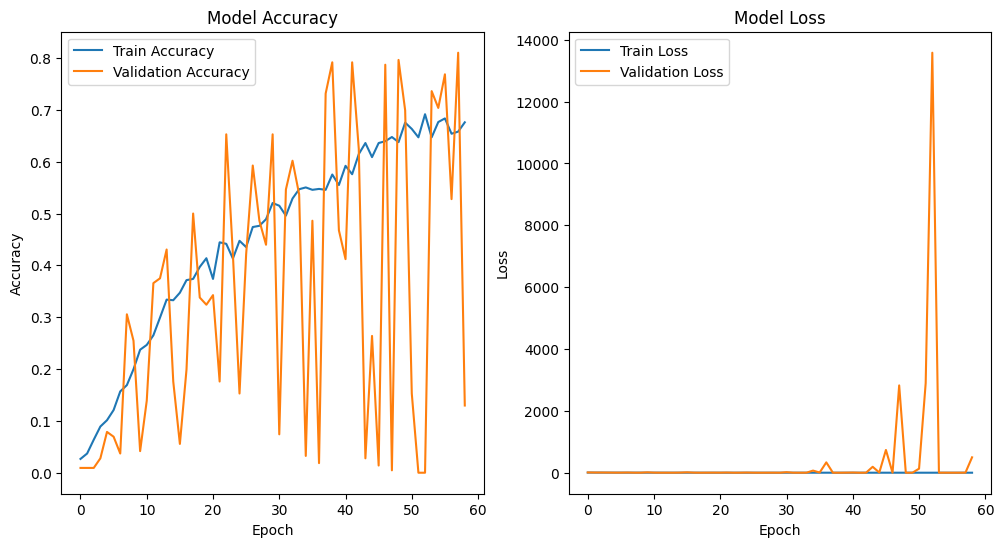

In [13]:
#Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

#Model accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history7.history['accuracy'], label='Train Accuracy')
plt.plot(history7.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

#Model loss plot
plt.subplot(1, 2, 2)
plt.plot(history7.history['loss'], label='Train Loss')
plt.plot(history7.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

The sixth improvement significantly increased the model's complexity by increasing the number of neurons and reduced the epochs to 59, but this led to severe overfitting and incredible instability in validation performance. The test accuracy was only 10.65%, indicating that the model was unable to generalize to new data, though the graph is very erratic.

### Model Improvement Attempt 7

The seventh improvement attempt involved reducing the intensity of image augmentation techniques (lowering the rotation, shift, and zoom ranges), decreasing the dropout rate in the fully connected layers from 0.5 to 0.3, increasing the epochs back to 100, and maintaining the same number of neurons and the learning rate at 0.0007 to improve generalization.

In [14]:
#Augmentation
datagen = ImageDataGenerator(
    rotation_range=5, #Lower rotation, shift, and zoom ranges
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest'
)

#Fit the data generator
datagen.fit(train_images)

input_shape = (100, 100, 1)
num_classes = 108

model8 = Sequential()

#First Convolutional Block
model8.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))  #Increased all neurons
model8.add(BatchNormalization())
model8.add(MaxPooling2D(pool_size=(2, 2)))
model8.add(Dropout(0.3))

#Second Convolutional Block
model8.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model8.add(BatchNormalization())
model8.add(MaxPooling2D(pool_size=(2, 2)))
model8.add(Dropout(0.3))

#Third Convolutional Block
model8.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model8.add(BatchNormalization())
model8.add(MaxPooling2D(pool_size=(2, 2)))
model8.add(Dropout(0.3))

#Fourth Convolutional Block
model8.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model8.add(BatchNormalization())
model8.add(MaxPooling2D(pool_size=(2, 2)))
model8.add(Dropout(0.3))

#Flatten the output of the last convolutional layer
model8.add(Flatten())

#Fully Connected Block
model8.add(Dense(512, activation='relu'))
model8.add(BatchNormalization())
model8.add(Dropout(0.3)) #Decreasing the dropout rate in the dense layers

model8.add(Dense(256, activation='relu')) 
model8.add(Dropout(0.3))  

#Output Layer
model8.add(Dense(num_classes, activation='softmax'))
model8.compile(optimizer=Adam(learning_rate=0.0007), loss='categorical_crossentropy', metrics=['accuracy'])
model8.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 100, 100, 64)      640       
                                                                 
 batch_normalization_10 (Bat  (None, 100, 100, 64)     256       
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 50, 50, 64)       0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 50, 50, 64)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 batch_normalization_11 (Bat  (None, 50, 50, 128)     

In [15]:
history8 = model8.fit(
    datagen.flow(train_images, train_labels_categorical, batch_size=32),
    validation_data=(val_images, val_labels_categorical),  
    epochs= 100, #Increase the epochs back to 100
    verbose=1
)

Epoch 1/100
54/54 [==============================] - 7s 75ms/step - loss: 4.8365 - accuracy: 0.0347 - val_loss: 7.6762 - val_accuracy: 0.0139
Epoch 2/100
54/54 [==============================] - 4s 71ms/step - loss: 4.0442 - accuracy: 0.0949 - val_loss: 8.9627 - val_accuracy: 0.0139
Epoch 3/100
54/54 [==============================] - 4s 69ms/step - loss: 3.5535 - accuracy: 0.1441 - val_loss: 11.1179 - val_accuracy: 0.0139
Epoch 4/100
54/54 [==============================] - 4s 69ms/step - loss: 3.1247 - accuracy: 0.2101 - val_loss: 9.1039 - val_accuracy: 0.0139
Epoch 5/100
54/54 [==============================] - 4s 69ms/step - loss: 2.7874 - accuracy: 0.2627 - val_loss: 11.1883 - val_accuracy: 0.0139
Epoch 6/100
54/54 [==============================] - 4s 69ms/step - loss: 2.4872 - accuracy: 0.3125 - val_loss: 8.3912 - val_accuracy: 0.0139
Epoch 7/100
54/54 [==============================] - 4s 70ms/step - loss: 2.2790 - accuracy: 0.3472 - val_loss: 8.4869 - val_accuracy: 0.0370
Epoc

In [16]:
#Evaluate the model on the test set
test_loss, test_accuracy = model8.evaluate(test_images, test_labels_categorical, verbose=1)
print(f'Test Accuracy: {test_accuracy:.4f}')

7/7 [==============================] - 0s 16ms/step - loss: 1.0508 - accuracy: 0.7593
Test Accuracy: 0.7593


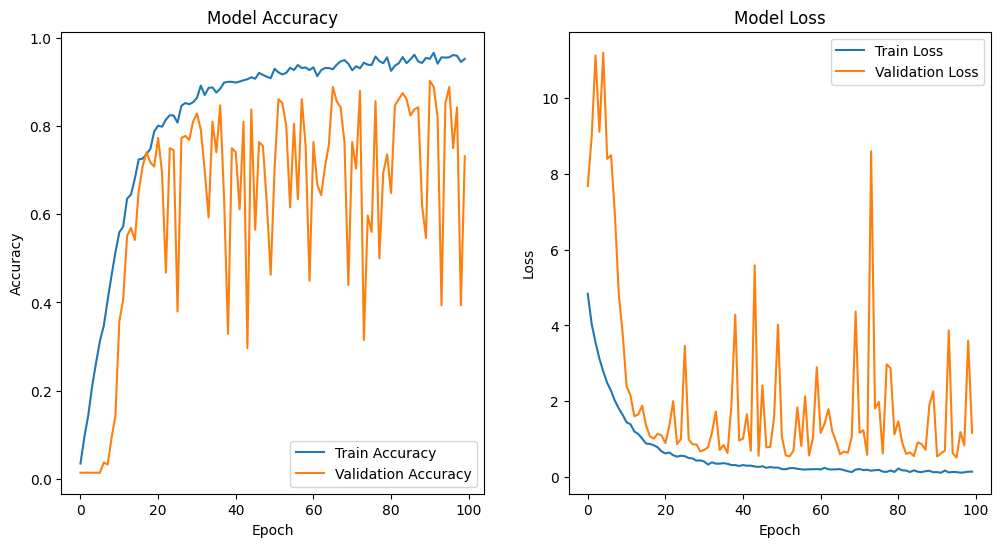

In [17]:
#Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

#Model accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history8.history['accuracy'], label='Train Accuracy')
plt.plot(history8.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

#Model loss plot
plt.subplot(1, 2, 2)
plt.plot(history8.history['loss'], label='Train Loss')
plt.plot(history8.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

The seventh improvement led to better training accuracy and improved test accuracy at 75.93%, with less severe validation fluctuations compared to previous models. However, there is still room to stabilize the model's generalization performance, reduce the validation loss spikes further, and reduce overfitting.

### Model Improvement Attempt 8

The eighth improvement attempt involved increasing the intensity of the data augmentation techniques (rotation, shift, and zoom range), increasing the dropout rate in the fully connected layers from 0.3 to 0.5 for better regularization, and reducing the learning rate to 0.0003 for improved stability. Additionally, the batch size was decreased from 32 to 16, an increase in epochs to get better training, and a learning rate scheduler (ReduceLROnPlateau) was introduced to adjust the learning rate dynamically when the validation loss plateaus, all aiming for better performance.

In [27]:
#Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,  #Increase rotation range
    width_shift_range=0.1,  #Increase horizontal shift
    height_shift_range=0.1,  #Increase vertical shift
    zoom_range=0.1,  #Increase zoom range
    horizontal_flip=True,
    fill_mode='nearest'
)

#Fit the data generator
datagen.fit(train_images)

#Define model input shape and number of classes
input_shape = (100, 100, 1)
num_classes = 108

#Model architecture
model8 = Sequential()

#First Convolutional Block
model8.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
model8.add(BatchNormalization())
model8.add(MaxPooling2D(pool_size=(2, 2)))
model8.add(Dropout(0.3))

#Second Convolutional Block
model8.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model8.add(BatchNormalization())
model8.add(MaxPooling2D(pool_size=(2, 2)))
model8.add(Dropout(0.3))

#Third Convolutional Block
model8.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model8.add(BatchNormalization())
model8.add(MaxPooling2D(pool_size=(2, 2)))
model8.add(Dropout(0.3))

#Fourth Convolutional Block
model8.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model8.add(BatchNormalization())
model8.add(MaxPooling2D(pool_size=(2, 2)))
model8.add(Dropout(0.3))

#Flatten the output of the last convolutional layer
model8.add(Flatten())

#Fully Connected Block
model8.add(Dense(512, activation='relu'))
model8.add(BatchNormalization())
model8.add(Dropout(0.5))  #Increased dropout for regularization

model8.add(Dense(256, activation='relu'))
model8.add(Dropout(0.5))  #Increased dropout for regularization

#Output Layer
model8.add(Dense(num_classes, activation='softmax'))

#Compile the model with a reduced learning rate and Adam optimizer
model8.compile(optimizer=Adam(learning_rate=0.0003), loss='categorical_crossentropy', metrics=['accuracy']) #Reduced learning rate for better stability

#Learning rate scheduler to reduce learning rate when the validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

model8.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 100, 100, 64)      640       
                                                                 
 batch_normalization_20 (Bat  (None, 100, 100, 64)     256       
 chNormalization)                                                
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 50, 50, 64)       0         
 g2D)                                                            
                                                                 
 dropout_24 (Dropout)        (None, 50, 50, 64)        0         
                                                                 
 conv2d_17 (Conv2D)          (None, 50, 50, 128)       73856     
                                                                 
 batch_normalization_21 (Bat  (None, 50, 50, 128)     

In [28]:
history8 = model8.fit(
    datagen.flow(train_images, train_labels_categorical, batch_size=16),  #Reduced batch size to 16
    validation_data=(val_images, val_labels_categorical),
    epochs=150,  #Increased epochs for better training
    verbose=1,
    callbacks=[reduce_lr]  #Added learning rate scheduler
)

Epoch 1/150
108/108 [==============================] - 8s 44ms/step - loss: 5.6779 - accuracy: 0.0087 - val_loss: 6.5841 - val_accuracy: 0.0139 - lr: 3.0000e-04
Epoch 2/150
108/108 [==============================] - 5s 42ms/step - loss: 5.1031 - accuracy: 0.0214 - val_loss: 9.7520 - val_accuracy: 0.0139 - lr: 3.0000e-04
Epoch 3/150
108/108 [==============================] - 5s 42ms/step - loss: 4.8462 - accuracy: 0.0388 - val_loss: 14.5382 - val_accuracy: 0.0139 - lr: 3.0000e-04
Epoch 4/150
108/108 [==============================] - 5s 42ms/step - loss: 4.6833 - accuracy: 0.0394 - val_loss: 16.8110 - val_accuracy: 0.0046 - lr: 3.0000e-04
Epoch 5/150
108/108 [==============================] - 5s 42ms/step - loss: 4.6094 - accuracy: 0.0382 - val_loss: 6.1774 - val_accuracy: 0.0185 - lr: 3.0000e-04
Epoch 6/150
108/108 [==============================] - 5s 45ms/step - loss: 4.3557 - accuracy: 0.0642 - val_loss: 4.6937 - val_accuracy: 0.0463 - lr: 3.0000e-04
Epoch 7/150
108/108 [===========

In [29]:
#Evaluate the model on the test set (optional step after training)
test_loss, test_accuracy = model8.evaluate(test_images, test_labels_categorical, verbose=1)
print(f'Test Accuracy: {test_accuracy:.4f}')

7/7 [==============================] - 0s 47ms/step - loss: 1.8464 - accuracy: 0.4352
Test Accuracy: 0.4352


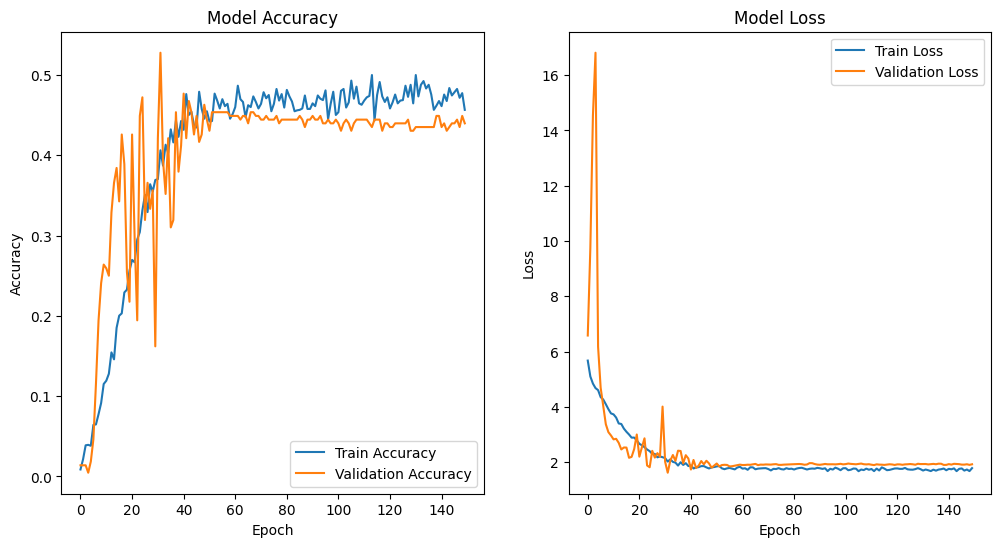

In [30]:
#Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

#Model accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history8.history['accuracy'], label='Train Accuracy')
plt.plot(history8.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

#Model loss plot
plt.subplot(1, 2, 2)
plt.plot(history8.history['loss'], label='Train Loss')
plt.plot(history8.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

After the eighth improvement, the model's training process exhibited more stable training accuracy with a noticeable improvement compared to earlier models. The loss and accuracy graphs show that the training and validation accuracy converged around 50%. However, the model's final test accuracy was 43.52%, which indicates the model might still have difficulties generalizing well to unseen data. Despite these changes, the performance gap between training and validation accuracy suggests there might still be slight overfitting. Increasing the training epochs and introducing the learning rate scheduler did help in refining the learning process, but further tuning may be required to push the model beyond this performance plateau.

### Final Model Improvement

The final improvement attempt involved several significant changes to the model. First, the number of filters in all convolutional blocks was increased, and L2 regularization was added to every convolutional and dense layer to prevent overfitting. LeakyReLU was used as the activation function across all convolutional layers to improve learning capacity, especially for sparse activations. Additionally, a fifth convolutional block was introduced to add more complexity to the model. The dropout rate in the fully connected layers was maintained, and the learning rate was slightly increased to 0.0005 for a faster learning process. These changes aimed to further combat both overfitting and underfitting, improving the model's ability to generalize well.

In [31]:
from tensorflow.keras.layers import LeakyReLU

#Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,   #Increased rotation range
    width_shift_range=0.1,  #Increased shift range
    height_shift_range=0.1,
    zoom_range=0.1,  #Increased zoom range
    horizontal_flip=True,
    fill_mode='nearest'
)

#Fit the data generator
datagen.fit(train_images)

#Define model input shape and number of classes
input_shape = (100, 100, 1)
num_classes = 108

#Model architecture
model8 = Sequential()

#First Convolutional Block with LeakyReLU
model8.add(Conv2D(128, (3, 3), padding='same', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.001)))  #Increased filters and added L2 regularization for all blocks
model8.add(LeakyReLU(alpha=0.1))  # Leaky ReLU activation
model8.add(BatchNormalization())
model8.add(MaxPooling2D(pool_size=(2, 2)))
model8.add(Dropout(0.3))

#Second Convolutional Block
model8.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.001))) 
model8.add(LeakyReLU(alpha=0.1))
model8.add(BatchNormalization())
model8.add(MaxPooling2D(pool_size=(2, 2)))
model8.add(Dropout(0.3))

#Third Convolutional Block
model8.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.001)))
model8.add(LeakyReLU(alpha=0.1))
model8.add(BatchNormalization())
model8.add(MaxPooling2D(pool_size=(2, 2)))
model8.add(Dropout(0.3))

#Fourth Convolutional Block
model8.add(Conv2D(1024, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.001)))
model8.add(LeakyReLU(alpha=0.1))
model8.add(BatchNormalization())
model8.add(MaxPooling2D(pool_size=(2, 2)))
model8.add(Dropout(0.3))

#Fifth Convolutional Block (newly added for more complexity)
model8.add(Conv2D(1024, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.001))) 
model8.add(LeakyReLU(alpha=0.1))
model8.add(BatchNormalization())
model8.add(MaxPooling2D(pool_size=(2, 2)))
model8.add(Dropout(0.3))

#Flatten the output of the last convolutional layer
model8.add(Flatten())

#Fully Connected Block
model8.add(Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model8.add(BatchNormalization())
model8.add(Dropout(0.5))

model8.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001))) 
model8.add(Dropout(0.5))

#Output Layer
model8.add(Dense(num_classes, activation='softmax'))

#Compile the model with a slightly increased learning rate
model8.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

#Learning rate scheduler to reduce learning rate when the validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

model8.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 100, 100, 128)     1280      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 100, 100, 128)     0         
                                                                 
 batch_normalization_25 (Bat  (None, 100, 100, 128)    512       
 chNormalization)                                                
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 50, 50, 128)      0         
 g2D)                                                            
                                                                 
 dropout_30 (Dropout)        (None, 50, 50, 128)       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 50, 50, 256)      

In [33]:
history8 = model8.fit(
    datagen.flow(train_images, train_labels_categorical, batch_size=16),
    validation_data=(val_images, val_labels_categorical),
    epochs=150,  #Increased epochs for better training
    verbose=1,
    callbacks=[reduce_lr]
)

Epoch 1/150
108/108 [==============================] - 13s 117ms/step - loss: 9.8759 - accuracy: 0.0422 - val_loss: 14.6895 - val_accuracy: 0.0046 - lr: 5.0000e-04
Epoch 2/150
108/108 [==============================] - 12s 110ms/step - loss: 9.3728 - accuracy: 0.0625 - val_loss: 12.0675 - val_accuracy: 0.0139 - lr: 5.0000e-04
Epoch 3/150
108/108 [==============================] - 12s 110ms/step - loss: 8.8724 - accuracy: 0.1007 - val_loss: 10.9485 - val_accuracy: 0.0046 - lr: 5.0000e-04
Epoch 4/150
108/108 [==============================] - 12s 112ms/step - loss: 8.4803 - accuracy: 0.1094 - val_loss: 10.1909 - val_accuracy: 0.0231 - lr: 5.0000e-04
Epoch 5/150
108/108 [==============================] - 12s 114ms/step - loss: 8.1857 - accuracy: 0.1233 - val_loss: 8.6587 - val_accuracy: 0.0556 - lr: 5.0000e-04
Epoch 6/150
108/108 [==============================] - 13s 116ms/step - loss: 7.8110 - accuracy: 0.1528 - val_loss: 7.5008 - val_accuracy: 0.1667 - lr: 5.0000e-04
Epoch 7/150
108/10

In [34]:
#Evaluate the model on the test set
test_loss, test_accuracy = model8.evaluate(test_images, test_labels_categorical, verbose=1)
print(f'Test Accuracy: {test_accuracy:.4f}')

7/7 [==============================] - 0s 57ms/step - loss: 0.9726 - accuracy: 0.9676
Test Accuracy: 0.9676


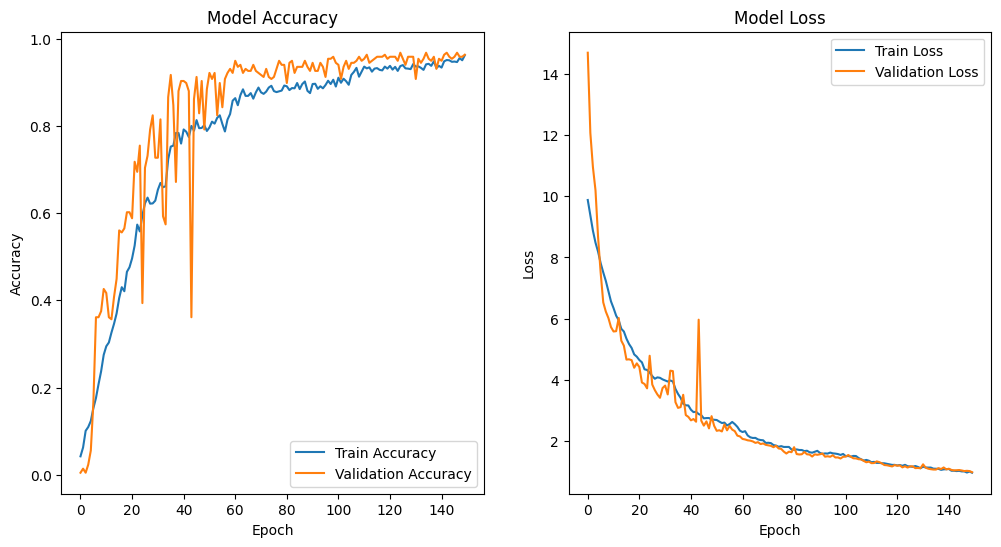

In [35]:
#Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

#Model accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history8.history['accuracy'], label='Train Accuracy')
plt.plot(history8.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

#Model loss plot
plt.subplot(1, 2, 2)
plt.plot(history8.history['loss'], label='Train Loss')
plt.plot(history8.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

After the final improvement, several changes were applied, including increasing the filters in each convolutional block, adding L2 regularization to the convolutional layers, and using Leaky ReLU activations. Additionally, a fifth convolutional block was added to increase model complexity. The learning rate was also slightly increased to 0.0005, and a learning rate scheduler (ReduceLROnPlateau) was used to reduce the learning rate when the validation loss plateaued.

These improvements yielded significant results, as seen by the final model's performance:
- Training accuracy reached 96.20%, while validation accuracy stabilized at 97.95%.
- The model generalization was excellent, achieving a 96.76% test accuracy, indicating little to no overfitting.
- Both the training and validation losses decreased significantly, showing smooth convergence without erratic behavior, confirming that the model maintained stability and learned well throughout the training process.

The combination of added complexity (through additional filters and layers), regularization, and an appropriate learning rate adjustment helped the model perform optimally and achieve strong generalization.

In [36]:
#Save model for predicitons
model8.save('aksara_sunda_classifier.keras')

### Making Predictions

In [6]:
import json

# Create and save class indices from the label encoder
class_indices = {label: index for index, label in enumerate(label_encoder.classes_)}

# Save the class indices to a JSON file
with open('class_indices.json', 'w') as f:
    json.dump(class_indices, f)

print("Class indices have been saved to 'class_indices.json'")


Class indices have been saved to 'class_indices.json'


In [7]:
from tensorflow.keras.models import load_model
import numpy as np
from tensorflow.keras.preprocessing import image
import json
from PIL import Image

# Step 1: Load the saved model
model_path = 'aksara_sunda_classifier.keras'
model = load_model(model_path)

# Step 2: Load the class indices (mapping of class names to indices)
# Ensure this file was saved during training
with open('class_indices.json', 'r') as f:
    class_indices = json.load(f)

# Step 3: Reverse the dictionary to map indices back to class labels
class_labels = {v: k for k, v in class_indices.items()}

# Step 4: Define image dimensions
img_height, img_width = 100, 100

# List of image paths for prediction
sample_image_paths = [
    r'C:\Kuliah Tel U\KP\Data\predict\sample_image1.jpg',
    r'C:\Kuliah Tel U\KP\Data\predict\sample_image2.jpg',
    r'C:\Kuliah Tel U\KP\Data\predict\sample_image3.jpg',
    r'C:\Kuliah Tel U\KP\Data\predict\sample_image4.jpg',
    r'C:\Kuliah Tel U\KP\Data\predict\sample_image5.jpg',
    r'C:\Kuliah Tel U\KP\Data\predict\sample_image6.jpg',
    r'C:\Kuliah Tel U\KP\Data\predict\sample_image7.jpg',
    r'C:\Kuliah Tel U\KP\Data\predict\sample_image8.jpg',
    r'C:\Kuliah Tel U\KP\Data\predict\sample_image9.jpg',
    r'C:\Kuliah Tel U\KP\Data\predict\sample_image10.jpg',
    r'C:\Kuliah Tel U\KP\Data\predict\sample_image11.jpg',
    r'C:\Kuliah Tel U\KP\Data\predict\sample_image12.jpg',
    r'C:\Kuliah Tel U\KP\Data\predict\sample_image13.jpg',
]

# Step 5: Preprocess images and make predictions
for img_path in sample_image_paths:
    # Load and preprocess the image
    img = Image.open(img_path).convert('L')  # Convert to grayscale
    img = np.array(img.resize((img_height, img_width))) / 255.0  # Resize and normalize
    img = np.expand_dims(img, axis=-1)  # Add channel dimension for grayscale
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Step 6: Predict the class
    predictions = model.predict(img)
    predicted_class_index = np.argmax(predictions, axis=1)
    predicted_class = class_labels.get(predicted_class_index[0], "Unknown")

    print(f'Image: {img_path} - Predicted Class: {predicted_class}')


1/1 [==============================] - 6s 6s/step
Image: C:\Kuliah Tel U\KP\Data\predict\sample_image1.jpg - Predicted Class: hi
1/1 [==============================] - 0s 29ms/step
Image: C:\Kuliah Tel U\KP\Data\predict\sample_image2.jpg - Predicted Class: he
1/1 [==============================] - 0s 26ms/step
Image: C:\Kuliah Tel U\KP\Data\predict\sample_image3.jpg - Predicted Class: hé
1/1 [==============================] - 0s 34ms/step
Image: C:\Kuliah Tel U\KP\Data\predict\sample_image4.jpg - Predicted Class: he
1/1 [==============================] - 0s 49ms/step
Image: C:\Kuliah Tel U\KP\Data\predict\sample_image5.jpg - Predicted Class: hé
1/1 [==============================] - 0s 39ms/step
Image: C:\Kuliah Tel U\KP\Data\predict\sample_image6.jpg - Predicted Class: heu
1/1 [==============================] - 0s 38ms/step
Image: C:\Kuliah Tel U\KP\Data\predict\sample_image7.jpg - Predicted Class: heu
1/1 [==============================] - 0s 38ms/step
Image: C:\Kuliah Tel U\KP\Data\